loading survival probability from spatiocyte simulation data of A+B>B, and calculate the k(t)

In [2]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special

rm = 0.005  
L = 1.75
D = 1
kd= 4.0*math.pi*D*2*rm
r0=0.256318
N=4000
f=1.0208582
print('tm',(2*rm*f)**2/(6*D))
w = spatiocyte.SpatiocyteWorld(ones()*L,rm*f)
l1,l2,l3 = tuple(w.actual_lengths())
Vact=l1*l2*l3

def getkt2(st,t,Vr): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2:]-t[:-2])/N
    return ks

def getkt5(st,t,Vr): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

def getktexp(st,t,Vr):
    ks = np.array([-math.log(d)*Vr/tt/N for d,tt in zip(st[2:]/st[:-2],(t[2:]-t[:-2]))])
    return ks

def Phi(xx):
    return special.erfcx(xx)
    #return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = np.array([(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc])
    return kt1

def plotk(dat,k_factor,voxelr,lag,yl,m,ts):
    if m=='o': mark='ori'
    else: mark = 'corrected'
    print('kfactor='+str(k_factor))
    tc=dat[:,0][::lag]
    #print tc[1:]-tc[:-1]
    mnac=dat[:,1][::lag]
    ka = k_factor*kd
    kon = (ka*kd)/(ka+kd)
    tm =(2*voxelr)**2/(6*D)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    Vr = w.calculate_volume(ones()*L,voxelr)
    
    #ks = getkt2(mnac,tc,Vr)   
    #ks = getktexp(mnac,tc,Vr)   
    
    Pacc= ka/3/2**0.5/D/2/voxelr
    kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
    kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
    
    tau = ((ka*2*rm/(ka+kd))**2)/(D)
    intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tc]
    st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
    stsim = (mnac/N)    
    
    dst = (np.log(stsim[1:])-np.log(stsim[:-1]))/(N/Vact) #k(t)=dlnS(t)/dt/cb 
    dtc = tc[1:]-tc[:-1]
    midtc = np.array((tc[:-1]+tc[1:])*0.5)
    ks=np.array([-s/t for t,s in zip(dtc,dst)]    )
    kt1 = getktt(ka,kdd,rm,midtc) #Spatheory
    kt2 = getktt(ka,kd,rm,midtc)#CK theory
    index = [midtc>ts]
    erSCK=(np.mean((kt2[index]-ks[index])**2))**0.5
    erSST=(np.mean((kt1[index]-ks[index])**2))**0.5
    #ts=0.08#0.045
    #ll=-600
    #ksm = np.mean(ks[1:-1][ll:])#sim
    #kt1m = np.mean(kt1[1:-1][ll:])#spa theory
    #kt2m = np.mean(kt2[1:-1][ll:])#CK theory
    #ksm = np.mean(ks[midtc>ts])#sim
    kt1m = kt1[-1]#np.mean(kt1[tc[1:-1]>ts])#spa theory
    kt2m = kt2[-1]#np.mean(kt2[tc[1:-1]>ts])#CK theory 
    print('no of points >ts,',len(midtc[midtc>ts]))
    print('ka={:.3},kd={:.3},kon={:.3},keffSpatheory={:.4},kdd={:.4}'.format(ka,kd,kon,kefftheory,kdd))
    #print('Spatheory={:.4}, CKtheory={:.4}, Sim={:.4}'.format(kt1m,kt2m,ksm))
    print('error btwn keffCK-Spatheory={:.4}'.format((kon-kefftheory)*100/kon))
    print('error btwn last kCK-kSpatheory={:.4}'.format((kt1m-kt2m)*100/kt2m))
    print('rmse btwn sim-Spatheory={:.3E}, for t>{:.3}'.format(erSST,ts))
    print('rmse btwn sim-CKtheory={:.3E}, for t>{:.3}'.format(erSCK,ts))
    #print('error btwn CK-Spatheory={:.4}'.format((kt1m-kt2m)*100/kt2m))
    #print('error bwtn sim-Spatheory={:.4}'.format((ksm-kt1m)*100/kt1m),'for t>'+str(ts))#'for last'+str(abs(ll))+'points'    )
    #print('error bwtn sim-CK={:.4}'.format((ksm-kt2m)*100/kt2m),'for t>'+str(ts))#'for last'+str(abs(ll))+'points'    )

    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))
    ax1.plot(midtc,ks,'r.',label='Sim '+mark)
    ax1.plot(midtc,kt1,'k--',label='kt_spatheory')
    ax1.plot(midtc,kt2,'b-.',label='kt_CK')
    ax1.set_ylabel('k(t)')
    ax1.set_xlabel('t')
    #plt.ylim([0.11,0.13])
    ax1.legend()
    if len(yl)!=0:
        ax1.set_ylim([yl[0],yl[1]])
        

    ax2.plot(tc,stsim,'g.',label='Sim '+mark+' $k_a/k_D=$'+str(k_factor))
    ax2.plot(tc,st,'c-',label='Theory $k_a/k_D=$'+str(k_factor))
    ax2.legend(loc='best')
    print(st[tc>0.009][0])
    ax2.set_ylabel('Survival probability of A')
    ax2.set_xlabel('time')
    

    
    #plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)            
    #return tc[1:-1],np.array(ks)/kon,np.array(kt2)/kon
    #return #tc,mnac/N,st
    #return


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


tm 1.7369191075120664e-05


kfactor=1.0
no of points >ts, 71
ka=0.126,kd=0.126,kon=0.0628,keffSpatheory=0.06218,kdd=0.1231
error btwn keffCK-Spatheory=1.032
error btwn last kCK-kSpatheory=-1.023
rmse btwn sim-Spatheory=2.392E-04, for t>0.04
rmse btwn sim-CKtheory=5.940E-04, for t>0.04
0.640947555975


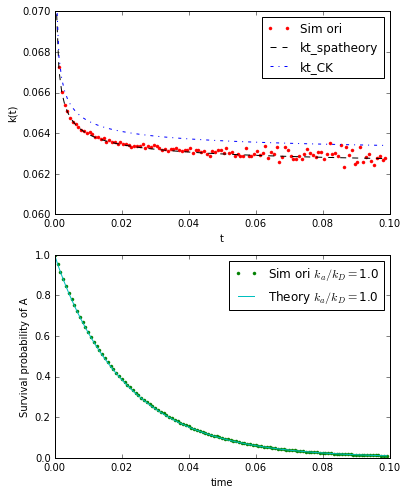

In [109]:
#dat = np.loadtxt('/home/chew/outputdata/kfac1.0a1meanNar50k',delimiter=',')
dat = np.loadtxt('/home/chew/outputdata/kfac1a1meanNa19996',delimiter=',')
plotk(dat,1.,rm,50,[0.06,0.07],'o',0.04)


kfactor=1.0
no of points >ts, 11
ka=0.126,kd=0.126,kon=0.0628,keffSpatheory=0.06283,kdd=0.1257
error btwn keffCK-Spatheory=2.946e-06
error btwn last kCK-kSpatheory=-2.909e-06
rmse btwn sim-Spatheory=1.207E-04, for t>0.04
rmse btwn sim-CKtheory=1.207E-04, for t>0.04
0.629588069099


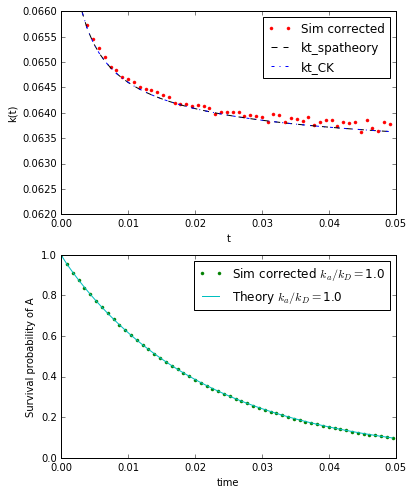

In [96]:
dat = np.loadtxt('/home/chew/outputdata/kfacc1.0a1meanNar50k',delimiter=',')
#dat = np.loadtxt('/home/chew/outputdata/kfacc1a1meanNa20000',delimiter=',')[:7000]

#t1c,k1c,kt1c=plotk(dat,1.,f*rm,5,[0.06,0.07],'c')
#plotk(dat,1.,f*rm,1,[0.06,0.07],'c',0.045)
plotk(dat,1.,f*rm,50,[0.062,0.066],'c',0.04)
#t1,sts1,stt1=plotk(dat,1.,f*rm,1,[0.06,0.07],'c')

In [308]:
dat = np.loadtxt('/home/chew/outputdata/kfac10.0a1meanNar50k',delimiter=',')
ks=plotk(dat,100,rm,1,[0.115,0.13],'o',)


TypeError: plotk() missing 1 required positional argument: 'ts'

kfactor=10.0
ka 1.2566370614359172 kd 0.12566370614359174 kon 0.11423973285781067 keffSpatheory 0.11423972673810245 kdd 0.12566369873874483
Spatheory CKtheory Sim 0.117071505406 0.117013653774 0.117346916986
error btwn keffCK-Spatheory 5.356899967563127e-06
error btwn CK-Spatheory 0.0494400695525
error bwtn sim-Spatheory 0.235250737814 for last600points
error bwtn sim-CK 0.284807115495 for last600points


(array([  3.53202212e-05,   5.26810079e-05,   7.00417945e-05, ...,
          4.99368063e-02,   4.99541671e-02,   4.99715278e-02]),
 array([ 1.89504817,  1.70615662,  1.61571248, ...,  1.01850529,
         1.01226008,  1.00978528]),
 array([ 2.18416429,  1.85325805,  1.70123429, ...,  1.0229479 ,
         1.02294391,  1.02293993]))

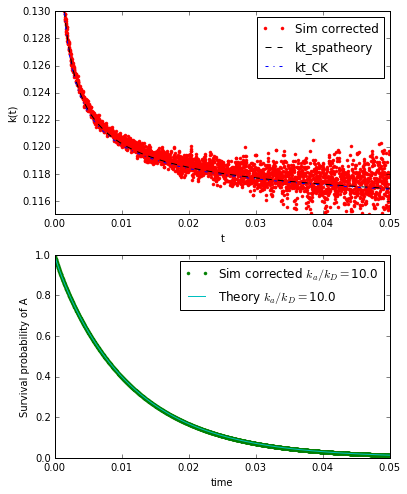

In [11]:
dat = np.loadtxt('/home/chew/outputdata/kfacc10.0a1meanNar50k',delimiter=',')
plotk(dat,10.,f*rm,1,[0.115,0.13],'c')

kfactor=10.0
ka 1.2566370614359172 kd 0.12566370614359174 kon 0.11423973285781067 keffSpatheory 0.11423972673810245 kdd 0.12566369873874483
Spatheory CKtheory Sim 0.117071514244 0.117013662432 0.117241731174
error btwn keffCK-Spatheory 5.356899967563127e-06
error btwn CK-Spatheory 0.0494402202139
error bwtn sim-Spatheory 0.145395684933 for last600points
error bwtn sim-CK 0.194907789094 for last600points


(array([  3.47814381e-05,   5.21422248e-05,   6.95030115e-05, ...,
          4.99364471e-02,   4.99538079e-02,   4.99711687e-02]),
 array([ 1.91641306,  1.71198953,  1.61512599, ...,  1.02093245,
         0.98780351,  0.99992589]),
 array([ 2.20156705,  1.85969402,  1.70479289, ...,  1.02294798,
         1.02294399,  1.02294   ]))

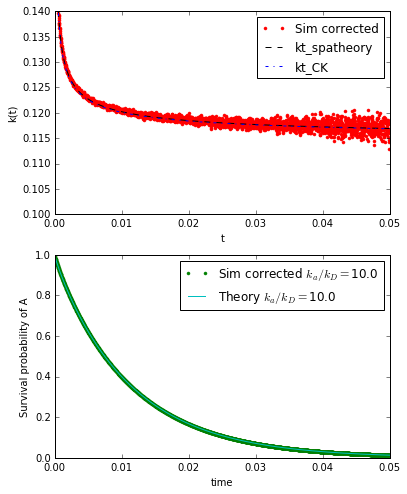

In [12]:
dat = np.loadtxt('/home/chew/outputdata/kfacc10.0a01meanNar50k',delimiter=',')
plotk(dat,10.,f*rm,1,[0.1,0.14],'c')

kfactor=100
no of points >ts, 11
ka=12.6,kd=0.126,kon=0.124,keffSpatheory=0.1219,kdd=0.1231
error btwn keffCK-Spatheory=2.023
error btwn last kCK-kSpatheory=-2.023
rmse btwn sim-Spatheory=3.605E-04, for t>0.04
rmse btwn sim-CKtheory=2.362E-03, for t>0.04
0.394356101231


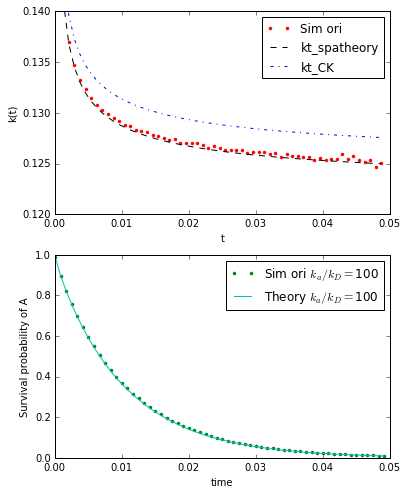

In [98]:
dat = np.loadtxt('/home/chew/outputdata/kfac100.0a1meanNar50k',delimiter=',')
plotk(dat,100,rm,50,[0.12,0.14],'o',0.04)

kfactor=100
no of points >ts, 73
ka=12.6,kd=0.126,kon=0.124,keffSpatheory=0.1244,kdd=0.1257
error btwn keffCK-Spatheory=5.834e-06
error btwn last kCK-kSpatheory=-5.833e-06
rmse btwn sim-Spatheory=4.436E-03, for t>0.04
rmse btwn sim-CKtheory=4.436E-03, for t>0.04
0.380135009861


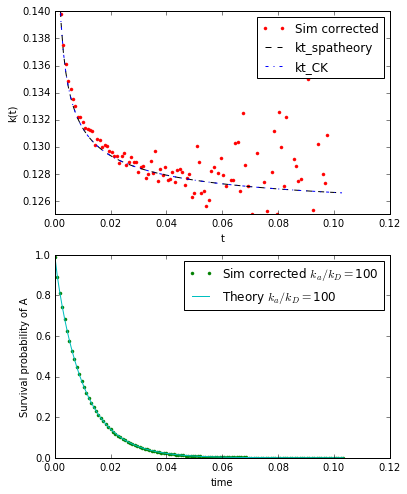

In [4]:
#dat = np.loadtxt('/home/chew/outputdata/kfacc100.0a1meanNar50k',delimiter=',')
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa5346',delimiter=',')[:6000]
#dat2 = np.loadtxt('data/kfacc100.0a01meanNar30k',delimiter=',')
plotk(dat,100,f*rm,50,[0.125,0.14],'c',0.04)
#plt.plot(dat[:,0][:5000],dat[:,1][:5000]/4000)
#t100c1,k100c1,kt100c1=plotk(dat1,100,f*rm,50,[0.125,0.14],'c')
#t100c2,k100c2,kt100c2=plotk(dat2,100,f*rm,50,[0.125,0.14],'c')
#plotk(dat,100,f*rm,50,[0.125,0.14],'c')
#plt.close("all")
#plt.plot(t100c1,k100c1,'r.')
#plt.plot(t100c2,k100c2,'k.')
#plt.ylim([1.02,1.1])

kfactor=0.1
ka=0.0126,kd=0.126,kon=0.0114,keffSpatheory=0.0114,kdd=0.1231
Spatheory=0.01143, CKtheory=0.01145, Sim=0.01143
error btwn keffCK-Spatheory=0.1893
error btwn CK-Spatheory=-0.1847
error bwtn sim-Spatheory=-0.001458 for last600points
error bwtn sim-CK=-0.1862 for last600points


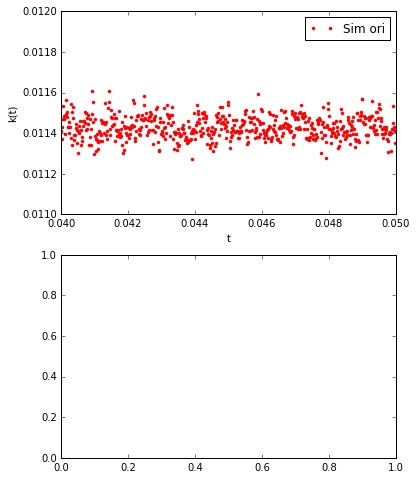

In [39]:
dat = np.loadtxt('/home/chew/outputdata/kfac0.1a1meanNar50k',delimiter=',')
ks=plotk(dat,0.1,rm,1,[0.011,0.012],'o')


kfactor=0.1
ka 0.0125663706144 kd 0.125663706144 kon 0.0114239732858 keffSpatheory 0.0114239732246 kdd 0.125663698739
Spatheory CKtheory Sim 0.0114716423992 0.0114706785381 0.0114683414389
error btwn keffCK-Spatheory 5.35690057496e-07
error btwn CK-Spatheory 0.0084028253443
error bwtn sim-Spatheory -0.0287749576977 for last600points
error bwtn sim-CK -0.0203745502628 for last600points


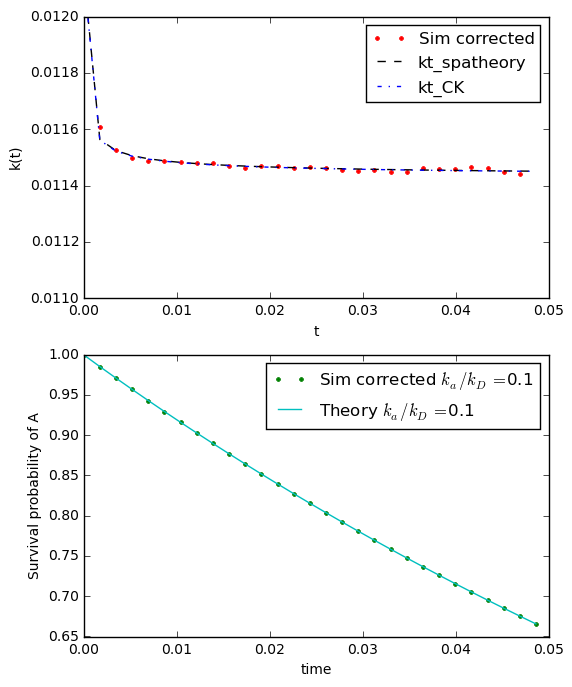

In [194]:
dat = np.loadtxt('kfacc0.1a1meanNar50k',delimiter=',')
#t01c,k01c,kt01c=plotk(dat,0.1,f*rm,5,[0.011,0.012],'c')
t01,sts01,stt01=plotk(dat,0.1,f*rm,100,[0.011,0.012],'c')

kfactor=0.01
ka 0.00125663706144 kd 0.125663706144 kon 0.00124419511033 keffSpatheory 0.00124393821541 kdd 0.123096134937
Spatheory CKtheory Sim 0.00124427275468 0.0012445229495 0.00124258840371
error btwn keffCK-Spatheory 0.0206474786635
error btwn CK-Spatheory -0.0201036723552
error bwtn sim-Spatheory -0.135368308203 for last600points
error bwtn sim-CK -0.155444766557 for last600points


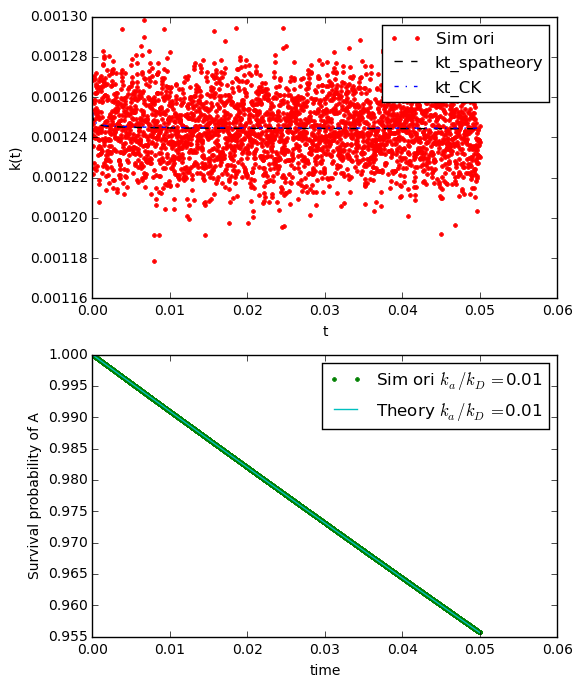

In [119]:
dat = np.loadtxt('kfac0.01a1meanNar50k',delimiter=',')
plotk(dat,0.01,rm,1,[],'o')

kfactor=0.01
ka 0.00125663706144 kd 0.125663706144 kon 0.00124419511033 keffSpatheory 0.00124419510961 kdd 0.125663698739
Spatheory CKtheory Sim 0.00124453065225 0.00124452381124 0.00124524723508
error btwn keffCK-Spatheory 5.83424709784e-08
error btwn CK-Spatheory 0.000549689321911
error bwtn sim-Spatheory 0.0575785596488 for last600points
error bwtn sim-CK 0.0581285654739 for last600points


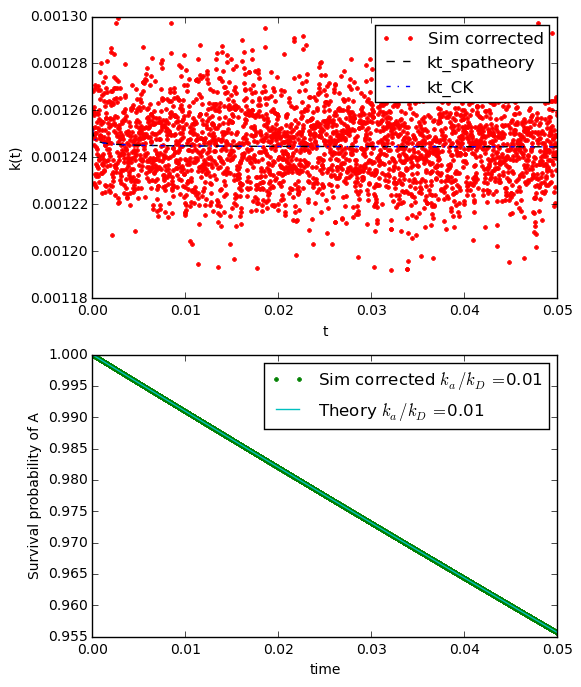

In [128]:
dat = np.loadtxt('kfacc0.01a1meanNar50k',delimiter=',')
plotk(dat,0.01,f*rm,1,[],'c')

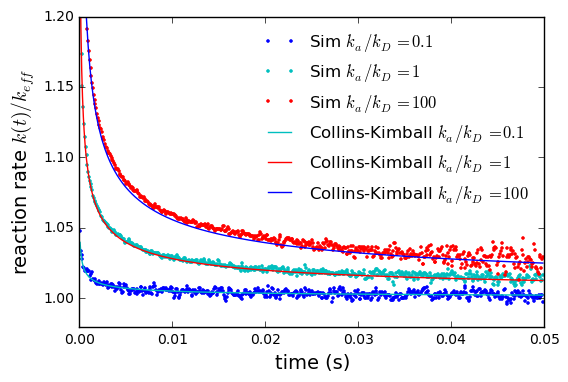

In [261]:
sz=4
plt.plot(t01c,k01c,'b.',markersize=sz,label='Sim $k_a/k_D=0.1$')
plt.plot(t1c,k1c,'c.',markersize=sz,label='Sim $k_a/k_D=1$')
plt.plot(t100c,k100c,'r.',markersize=sz,label='Sim $k_a/k_D=100$')

plt.plot(t01c,kt01c[1:-1],'c',label='Collins-Kimball $k_a/k_D=0.1$')
plt.plot(t1c,kt1c[1:-1],'r-',label='Collins-Kimball $k_a/k_D=1$')
plt.plot(t100c,kt100c[1:-1],'b',label='Collins-Kimball $k_a/k_D=100$')

plt.legend(loc='best',fontsize=12,frameon=False)
plt.ylim([0.98,1.2])
plt.ylabel('reaction rate $k(t)/k_{eff}$',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig("figure/kt.png",format='png',dpi=300)    

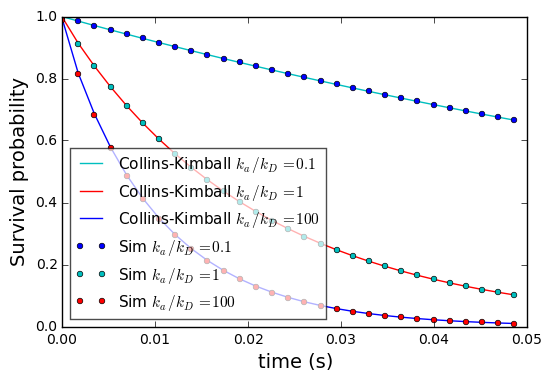

In [201]:
sz=4
plt.plot(t01,stt01,'c',label='Collins-Kimball $k_a/k_D=0.1$')
plt.plot(t1,stt1,'r-',label='Collins-Kimball $k_a/k_D=1$')
plt.plot(t100,stt100,'b',label='Collins-Kimball $k_a/k_D=100$')

plt.plot(t01,sts01,'bo',markersize=sz,label='Sim $k_a/k_D=0.1$')
plt.plot(t1,sts1,'co',markersize=sz,label='Sim $k_a/k_D=1$')
plt.plot(t100,sts100,'ro',markersize=sz,label='Sim $k_a/k_D=100$')

plt.legend(loc='lower left',fontsize=11,framealpha=0.7)
#plt.ylim([0,0.9])
plt.ylabel('Survival probability',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
plt.savefig("figure/st.png",format='png',dpi=300)    